### Link to [GitHub Repository](https://github.com/gwpicard/hand_digit_recognition)

In [8]:
# create folder for saving data
dir_ = 'data'
 
try:   
    os.mkdir(dir_)
    print(dir_,  "created") 
except FileExistsError:
    print(dir_, "folder already exists")
    
try:   
    os.mkdir(dir_+"/1")
    os.mkdir(dir_+"/2")
    os.mkdir(dir_+"/3")
    os.mkdir(dir_+"/4")
    os.mkdir(dir_+"/5")
    os.mkdir(dir_+"/6")
    print("Dataset folders for data capture created") 
except FileExistsError:
    print("Dataset folders for data capture already exist")

data folder already exists
Dataset folders for data capture already exist


# Final Assignment

_December 2018_

_Guillaume Picard_

_Assignment for Deep Learning Tutorial_ 

---

The goal of this assignment is to create a computer vision that can recognise basic hand signals -- it should be able to tell me the number I show with my right hand. This is as a sort of proof of concept for a potential sign language system. Given that this assignment is for Deep Learning, we will use a Deep Learning system to complete the task. Since we are starting from scratch, we will have two major tasks:

1. Choosing the data
2. Choosing the architecture

For 1, we decided to create our own data. This is easier to prototype with and we can easily add more if needed to improve our Neural Network's performance. For 2, we decided to use transfer learning -- this is because sophisticated architectures exist for image classification, and we can simply build on top of it to create a custom classification layer suited to our needs.

Since we will be creating our own dataset, we have a parallel program that we can use to complete all model functions on this notebook, as well as additional functions (such as testing the neural network inference in real time with our webcam).

In the home directory, there is a `video_stream.py` file that we used to capture our own data and create a dataset.  The easiest way to use it is by open a new terminal window and entering: `python3 video_stream.py --cat [cat] --n_photos [n_photos] `. The `[cat]` variable specifies the category for which you want to capture data (from 1 to 6, 6 being no digits being shown on fingers), and `[n_photos]` specifies the number of consecutive photos you want to capture for the dataset. Once some data has been captured, the following code can be run.

---
## Creating the Training Data

### Import dependencies

In [9]:
import pandas as pd
import numpy as np
import os
import shutil
import cv2

from collections import OrderedDict

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms, datasets, models
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from tqdm import tqdm_notebook

### Create directories for sorted data

We can create the correct training data folders after having captured a few images using the `video_stream.py` file. The following code organises the data into training, validation and testing sets appropriately.

In [10]:
# Create directory for all training/validation/testing datasets
dir_ = 'images'
 
try:   
    os.mkdir(dir_)
    print(dir_,  "created") 
except FileExistsError:
    print(dir_, "folder already exists")

images folder already exists


In [11]:
# Create directory for training, validation and test datasets
try:   
    os.mkdir(dir_+"/training")
    os.mkdir(dir_+"/validation")
    os.mkdir(dir_+"/testing")
    print("Dataset folders created") 
except FileExistsError:
    print("Dataset folders already exist")

Dataset folders already exist


In [13]:
# set pointer to captured data
all_image_folders = os.listdir("data/")
all_image_folders.remove('.DS_Store')

### Migrate dataset and split in training, validation and test

We don't shuffle the data indices so there's less correlation in data between the training/validation and testing datasets.

In [14]:
for image_folder in all_image_folders:
    all_images = np.array(os.listdir("data/"+image_folder))
    print("Folder",image_folder+":", len(all_images), "images")
    image_ind = np.array(range(len(all_images)))
    
    N = len(all_images) # total number of datapoints
    
    # define train, validation, test split - 50% (train), 20% (val), 30% (test)
    train_test_split = 0.7
    train_validation_split = 0.7
    train_validation_split = train_validation_split * train_test_split
    train, validation, test = np.split(image_ind, [int(train_validation_split*N), int(train_test_split*N)])
    
    print("Train/Valid/Test data split created..")
    
    source = "data/"+image_folder+"/"
    train_source_files = [source+file for file in all_images[train]]
    validation_source_files = [source+file for file in all_images[validation]]
    test_source_files = [source+file for file in all_images[test]]
    
    source_files = [train_source_files, validation_source_files, test_source_files]
    
    for ind, files in enumerate(source_files):
        
        if ind == 0:
            destination = "images/training/"+image_folder
        elif ind == 1:
            destination = "images/validation/"+image_folder
        else:
            destination = "images/testing/"+image_folder
        
        # remove previous data if present
        if os.path.isdir(destination):
            print("Removing previous data..")
            shutil.rmtree(destination)
        
        # create directories if they don't exist
        try:
            os.mkdir(destination)
            print(destination,"folder created..") 
        except FileExistsError:
            print(destination,"folders already exist..")
        
        # Copy files into respective directories
        for file in files:
            if file.endswith(".jpg"):
                shutil.copy(file, destination)
        
    print("Folder",image_folder,"copy complete\n")

Folder 6: 446 images
Train/Valid/Test data split created..
Removing previous data..
images/training/6 folder created..
Removing previous data..
images/validation/6 folder created..
Removing previous data..
images/testing/6 folder created..
Folder 6 copy complete

Folder 1: 446 images
Train/Valid/Test data split created..
Removing previous data..
images/training/1 folder created..
Removing previous data..
images/validation/1 folder created..
Removing previous data..
images/testing/1 folder created..
Folder 1 copy complete

Folder 4: 446 images
Train/Valid/Test data split created..
Removing previous data..
images/training/4 folder created..
Removing previous data..
images/validation/4 folder created..
Removing previous data..
images/testing/4 folder created..
Folder 4 copy complete

Folder 3: 446 images
Train/Valid/Test data split created..
Removing previous data..
images/training/3 folder created..
Removing previous data..
images/validation/3 folder created..
Removing previous data..
im

---

### Create PyTorch dataloaders

Once the data has been properly split by training,validation and testing, we can create PyTorch dataloaders from which to load our data. In order to properly training our network, our data needs to be standardised and cleaned. To do this, we resize all of our images down to a square format of (200,200), and normalise all of the pixel values using PyTorch transform functions. Additionally, We add from flips and rotations to our training dataset for data augmentation which will help improve training.

In [15]:
data_dir = 'images'
train_dir = data_dir + '/training'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/testing'

In [16]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)), # square resize
    transforms.RandomRotation(30), # random rotation transform
    transforms.RandomHorizontalFlip(), # random flip transform
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_test_transforms = transforms.Compose([
    transforms.Resize((200, 200)), # square resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

---

### View sample images from dataset

Now that we have prepped our data using PyTorch transforms, we can look at a batch sample to see if the data looks good (the way that our neural network will see it).

In [25]:
def show_image_samples(dataloader):
    '''
    View a batch sample of what the neural network will "see"
    '''
    batch, batch_labels = next(iter(dataloader))    
    grid = torchvision.utils.make_grid(batch) # make grid from images in batch
    
    # view grid with matplotlib
    plt.figure(figsize=(14,14))
    grid = grid.numpy().transpose(1,2,0).clip(0,1)
    plt.imshow(grid)
    plt.axis('off')

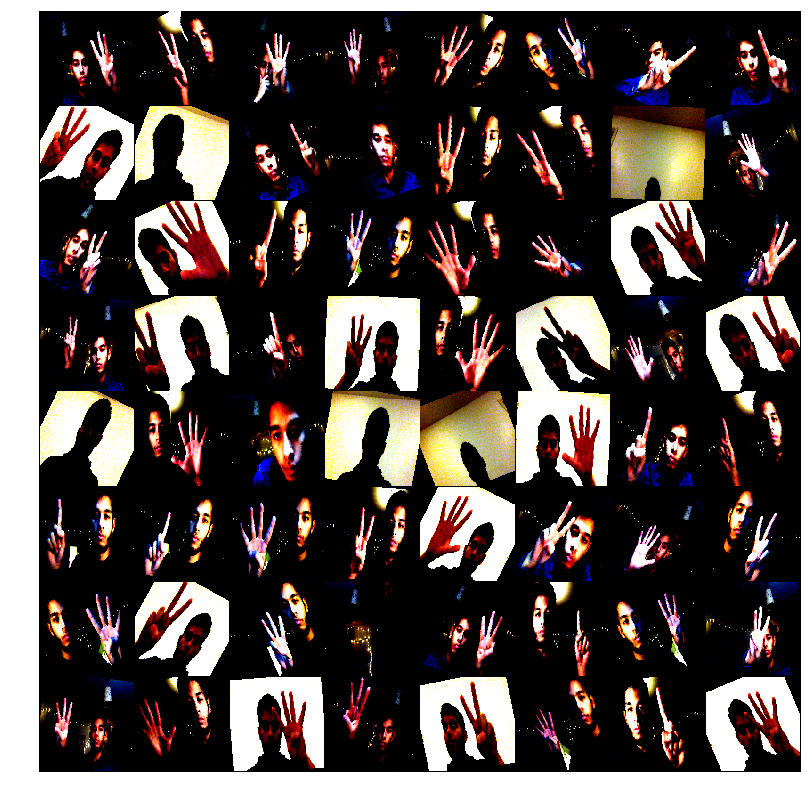

In [26]:
# Samples from training set
show_image_samples(trainloader)

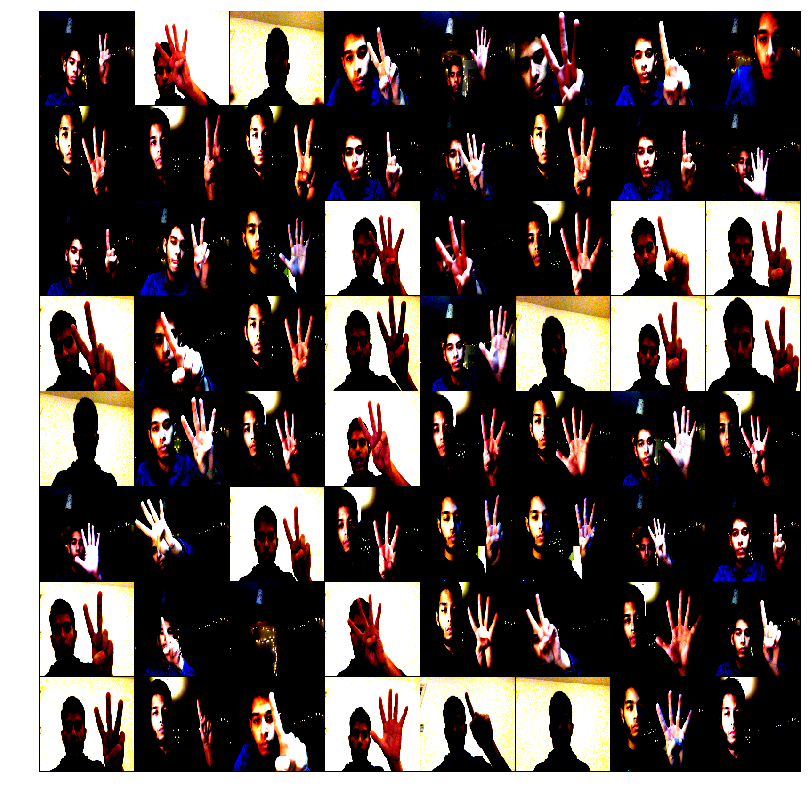

In [27]:
# Samples from test set
show_image_samples(testloader)

The data looks good! It appears as though there's not too much noise, and there is some variation given that we took the images with a few different backgrounds. The hand seems quite visible which should make the data easies to learn from for our model. If it fails to converge easily we will resort to some additional preprocessing.

---
## Building and Training the Model

### Define model for training

As we mentioned, we will use transfer learning to use a more powerful architecture to learn our features. However, we don't use the original model parameters for feature extract, and instead tweak the to match our problem more specifically (although we do import it pretrained). We chose ResNet 18 which has a good balance of performance of benchmark tests relative to the overall number of parameters. ResNet 18 uses a residual network architecture which have the property of being deeper (more layers) although maintaining a similar number of parameters compared to "shallower" networks (He, Zhang, Ren, & Sun, 2016). The goal of the residual network is to share features across layers as the network gets deeper, rather than only using outputs from only the previous layer to abstract information. In this way, network depth is able to benefit the network rather than hinder it.

In [17]:
# Import ResNet18
model = models.resnet18(pretrained=True)

In [18]:
# View ResNet18 fully connected output layer 
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


**Replace classifying layer of ResNet 18**

Since this is a transfer learning problem (the original ResNet is designed to classify images in 1000 categories), we take out the final layer and replace it with our own custom classfication layer. Our custom classfication layer has 6 outputs (for the 5 numbers and no number categories), and two hidden layers (to provide it with a bit of flexibility with ResNet's convolutional outputs). We include a ReLu activation and Dropout to help the classification train more easily and be more robust in its predictions, and finally output a log probabilities for each of the 6 categories.

In [19]:
num_ftrs = model.fc.in_features

# create custom classifier layer on top of VGG16
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 4096)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.3)),
    ('fc2', nn.Linear(4096, 6)), # for the 6 possible categories
    ('output', nn.LogSoftmax(dim=1))
]))
    
# replace VGG16 output classifying layer
model.fc = classifier

**Test forward propagation on model**

In [20]:
dat = next(iter(trainloader))
with torch.no_grad():
    model.forward(dat[0])

### Train model

Now that we have defined our model and checked it works with our data, we can define our training function. We use the Cross Entropy Loss function which is typically used for classification problems for neural networks. We also define stochastic gradient descent (SGD) for our optimiser with optional momentum, and a learning rate of 0.001. Our training function keeps track of loss over time as we train our model epoch to epoch.

In [18]:
# get GPU device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define loss function - CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()

# define Adam for fully-connected layer of model only (momentum-based)
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.5)

# send model to CPU/GPU
model.to(device);

In [32]:
# training params
epochs = 10
update_steps = 2

loss_hist = []

# train model
for e in tqdm_notebook(range(epochs)):
    model.train()
    steps = 0
    
    # tracking metrics for training
    n_data = 0
    running_loss = 0
    train_accuracy = 0
    for data, labels in trainloader:
        steps+=1
        
        # send data to GPU
        data, labels = data.to(device), labels.to(device)
        
        # feed forward data + calculate loss
        output = model.forward(data)
        loss = loss_function(output, labels)
        
        # backprop + gradient descent
        loss.backward()
        optimizer.step()
        
        # track training running loss
        running_loss += loss.item()*data.size(0)
        
        # track train accuracy counter
        _, pred = torch.max(output, 1)
        n_correct = torch.sum(labels.data == pred)
        train_accuracy += n_correct.double()
        
        # keep track of number of data points for averaging
        n_data += data.size(0)
        
        if steps % update_steps == 0:
            # track validation loss + accuracy
            valid_loss = 0
            valid_accuracy = 0
            
            model.eval() # evaluation mode
            with torch.no_grad():
                for data_v, labels_v in validloader: # iterate through validation data
                    
                    data_v, labels_v = data_v.to(device), labels_v.to(device)
                    output = model.forward(data_v)
                    v_loss = loss_function(output, labels_v)
                    
                    # update validation loss
                    valid_loss += v_loss.item()*data_v.size(0)
                    
                    # calculate valid accuracy for batch
                    _, pred = torch.max(output, 1)
                    n_correct = torch.sum(labels_v.data == pred)
                    valid_accuracy += n_correct.double()
            
            print("Epoch %d/%d.. Steps %d/%d.. "%(e+1, epochs, steps, len(trainloader)))
            train_str = "Training loss:  %.3f.. Training accuracy: %.3f.."%(running_loss/n_data, train_accuracy/n_data)
            val_str = "Validation loss:  %.3f.. Validation accuracy: %.3f.."%(valid_loss/len(validloader.dataset), valid_accuracy/len(validloader.dataset))
            print(train_str, val_str)
            
            # keep track of loss with training
            loss_hist.append([running_loss/n_data, valid_loss/len(validloader.dataset)])
            
            # reset tracking metrics
            running_loss = 0
            train_accuracy = 0
            n_data = 0
            
            model.train()

Epoch 1/10.. Steps 2/21.. 
Training loss:  1.814.. Training accuracy: 0.211.. Validation loss:  1.816.. Validation accuracy: 0.174..
Epoch 1/10.. Steps 4/21.. 
Training loss:  1.826.. Training accuracy: 0.180.. Validation loss:  1.817.. Validation accuracy: 0.167..
Epoch 1/10.. Steps 6/21.. 
Training loss:  1.885.. Training accuracy: 0.125.. Validation loss:  1.816.. Validation accuracy: 0.167..
Epoch 1/10.. Steps 8/21.. 
Training loss:  1.831.. Training accuracy: 0.180.. Validation loss:  1.737.. Validation accuracy: 0.243..
Epoch 1/10.. Steps 10/21.. 
Training loss:  1.768.. Training accuracy: 0.172.. Validation loss:  1.697.. Validation accuracy: 0.209..
Epoch 1/10.. Steps 12/21.. 
Training loss:  1.707.. Training accuracy: 0.164.. Validation loss:  1.687.. Validation accuracy: 0.504..
Epoch 1/10.. Steps 14/21.. 
Training loss:  1.828.. Training accuracy: 0.289.. Validation loss:  1.715.. Validation accuracy: 0.440..
Epoch 1/10.. Steps 16/21.. 
Training loss:  1.845.. Training accur

Epoch 7/10.. Steps 6/21.. 
Training loss:  0.222.. Training accuracy: 0.930.. Validation loss:  0.803.. Validation accuracy: 0.777..
Epoch 7/10.. Steps 8/21.. 
Training loss:  0.415.. Training accuracy: 0.875.. Validation loss:  0.714.. Validation accuracy: 0.819..
Epoch 7/10.. Steps 10/21.. 
Training loss:  0.233.. Training accuracy: 0.938.. Validation loss:  0.600.. Validation accuracy: 0.855..
Epoch 7/10.. Steps 12/21.. 
Training loss:  0.231.. Training accuracy: 0.922.. Validation loss:  0.671.. Validation accuracy: 0.871..
Epoch 7/10.. Steps 14/21.. 
Training loss:  0.441.. Training accuracy: 0.852.. Validation loss:  0.878.. Validation accuracy: 0.842..
Epoch 7/10.. Steps 16/21.. 
Training loss:  0.519.. Training accuracy: 0.859.. Validation loss:  1.057.. Validation accuracy: 0.830..
Epoch 7/10.. Steps 18/21.. 
Training loss:  0.602.. Training accuracy: 0.867.. Validation loss:  1.048.. Validation accuracy: 0.842..
Epoch 7/10.. Steps 20/21.. 
Training loss:  0.374.. Training acc

**Visualise historic loss with training**

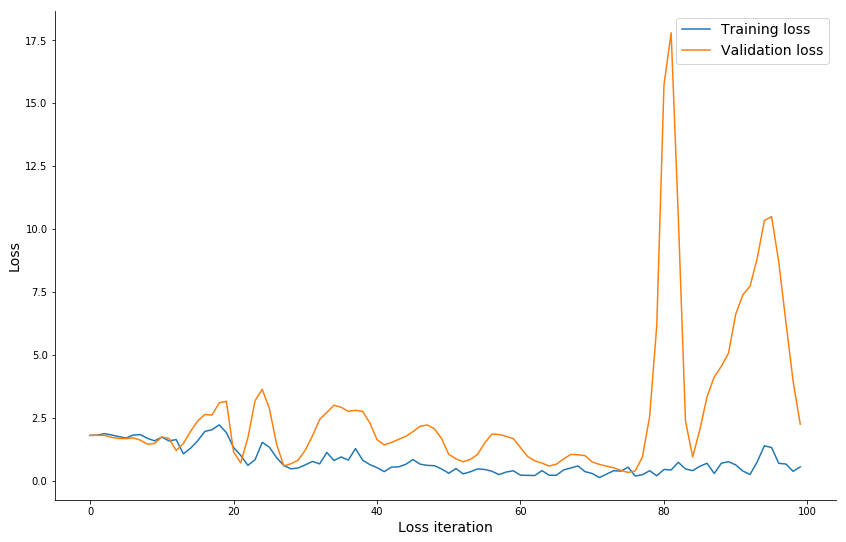

In [33]:
def plot_loss(loss_hist):
    
    loss_train, loss_val = zip(*loss_hist)
    
    plt.figure(figsize=(14, 9))
    
    ax = plt.subplot(111)
    
    ax.spines["top"].set_visible(False) 
    ax.spines["right"].set_visible(False)     

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.plot(loss_train, label="Training loss")
    ax.plot(loss_val, label="Validation loss")
    
    plt.xlabel("Loss iteration", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    
    plt.legend(fontsize=14)

    plt.show()

plot_loss(loss_hist)

We see that our training and validation loss tend to correlate initially as our model begins to learn, and then start to diverge as the model becomes more confident for the training data. Then, there are increasing oscilliations of validation error as training error reduces incrementally, most likely as the model learns to adapt to small changes in training data images which improves its ability to generalise to the validation data.

### Save model state after training

In [34]:
checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
             }

torch.save(checkpoint, 'checkpoint.pth')

---
## Evaluate model on Test Data

After training the model for an additional 7 epochs in the terminal and loading the saved checkpoint, we get the following performance on the test set

In [19]:
model.eval()

test_loss = 0
test_accuracy = 0
with torch.no_grad():
    for data, labels in testloader:
        
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        loss = loss_function(output, labels)
        
        test_loss += loss.item()*data.size(0)
        
        # calculate accuracy for batch
        _, pred = torch.max(output, 1)
        n_correct = torch.sum(labels.data == pred)
        test_accuracy += n_correct.double()
        
print("Test loss:  %.3f.. Test accuracy: %.3f.."%(test_loss/len(testloader.dataset), test_accuracy/len(testloader.dataset)))
model.train();

Test loss:  0.080.. Test accuracy: 0.976..


97.6% accuracy... not bad!

---

## Load Model and Test Inference Visually

We also want to test how the model predicts in different situations given samples from our training data.

**Load model parameters from checkpoint**

In [11]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# create custom classifier layer on top of VGG16
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 4096)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.3)),
    ('fc2', nn.Linear(4096, 6)), # for the 6 possible hand categories
    ('output', nn.LogSoftmax(dim=1))
]))
    
# replace VGG16 output classifying layer
model.fc = classifier

In [12]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval(); # set to eval - disable dropout

### Test model inference for test samples

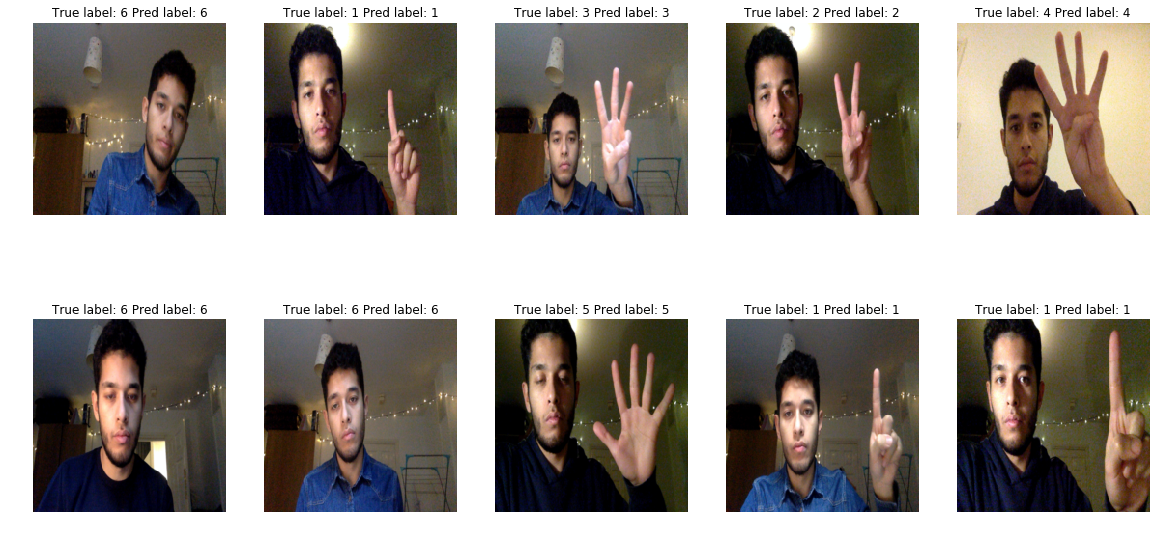

In [13]:
img_batch, labels = next(iter(testloader))

# select subset of images to test labelling
img_batch = img_batch[:10]

# compute most likely label for each image
with torch.no_grad():
    output = model.forward(img_batch)
    _, preds = torch.max(output, 1)

# set up figure
f, grid = plt.subplots(2, 5, figsize=(20,10))

# Plot true label and predicted label
for ind, i in enumerate(img_batch):
    inp = i.numpy().transpose((1, 2, 0))
    
    # reverse normalise image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    # plot image and label
    grid[int(ind/5), ind%5].imshow(inp, interpolation="nearest")
    grid[int(ind/5), ind%5].title.set_text('True label: '+str(labels[ind].numpy()+1)+' Pred label: '+str(preds[ind].numpy()+1))
    grid[int(ind/5), ind%5].axis('off')

plt.show()
    

It looks as though the model is performing well! It correctly predicts every image in each frame. Since these are frames, the system may perform just as well with live video data given that images are fed in sequence and correlated.
___

## Live Video feed test

Here is a short gif from a test of the vision systems - looks like it works decently!

![test_gif.gif](test_gif.gif)

---
## Conclusions and Further Work

The system appears to work and generalise quite well given the limited amount it was trained on (a total of 1,314 images in the training set overall). However, there are a few limitations given that the hand needs to have enough contrast with the background in order for the model to distinguish it properly (backlit webcam footage would probably not work well). For the system to generalise better to different settings and lighting conditions, further preprocessing would be needed to normalise the image (perhaps drawing a bounding box around the hand first and feeding that to the neural network), as well as using some more varied data. Additionally, we didn't take advantage of many more training tricks such as batch normalisation, different activation functions or varying architectures. Given the scope of the problem, what we had enabled us to get very good results on the training set which is why not much more experimentation was need on that end (it was a lot harder to get the training data captured and formatted properly).

---
# References

Balaji, N. (2017). Image Data Pre-Processing for Neural Networks – Becoming Human: Artificial Intelligence Magazine. Retrieved from https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

Open CV Docs. (2016). Contour Approximation Method. Retrieved from https://docs.opencv.org/3.2.0/d4/d73/tutorial_py_contours_begin.html

Open CV Docs. (2018). Contour Features. Retrieved from https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html